## What to do?

Just run the cells that you need.
There's different sections for the different model architectures

In [20]:
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from keras import backend as K
from time import time
from models import ResNet
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   


import training and validation data
not included in repo, set your own folder location

In [2]:
X_train = np.load('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

In [3]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'house', 'nine', 'four', 'happy', 'wow', 'five', 'zero', 'tree', 'six', 'one', 'three', 'eight', 'cat', 'two', 'seven', 'marvin', 'dog', 'sheila', 'bed', 'bird']


The training data is very unbalanced with a much larger 'unknown' class.
keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [ ]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [ ]:
class_weights

some constants we need for all models

In [4]:
input_size = X_train.shape[1:]
batch_size = 196

## First the ResNet
declare filters for each block of blocks and set output size.

In [ ]:
filters_list = [8,16,32]
output_size = 12

In [5]:
#adjust these strings for organizeing the saved files
date = '1003'
arch = 'resnet8_16_32'

Build the model

In [ ]:
sr = ResNet(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])

In [ ]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [ ]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

train the model
the history object stores training data for later access, like plotting training curves

In [ ]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 5, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


plot the training graphs, and save them

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

predict the validation classification and score

In [ ]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

In [ ]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

In [ ]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

## Now the CTC model

In [6]:
from models import CTC, ctc_lambda_func #used in the CTC build method
from ctc_utils import char_map, index_map, text_to_int, get_intseq, get_ctc_params

In [7]:
# dummy loss
def ctc(y_true, y_pred):
    return y_pred

The Conv1D layer at the top of the CTC model takes a 3-dimensional input, not 4 as the ResNet

In [8]:
sr_ctc = CTC((122,85), 28)
sr_ctc.build()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


(<keras.engine.training.Model at 0x7f0d1cf29ef0>,
 <keras.engine.training.Model at 0x7f0d1d0297f0>)

In [9]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')

In [10]:
Y_train_all = np.load('data/Y_train_all.npy')
Y_val_all = np.load('data/Y_val_all.npy')

get the ctc parameters needed for the three extra ctc model inputs

In [11]:
labels, input_length, label_length = get_ctc_params(Y = Y_train_all, classes_list = all_classes)
labels_val, input_length_val, label_length_val = get_ctc_params(Y = Y_val_all, classes_list = all_classes)

In [12]:
checkpointer = ModelCheckpoint(filepath="./models/ctc_{}_best.h5".format(date),
                               verbose=0,
                               save_best_only=True)

In [13]:
history = sr_ctc.m.fit([np.squeeze(X_train), 
                            labels, 
                            input_length, 
                            label_length], 
                       np.zeros([len(Y_train_all)]), 
                       batch_size = 128, 
                       epochs = 10, 
                       validation_data = ([np.squeeze(X_val), 
                                           labels_val, 
                                           input_length_val, 
                                           label_length_val],
                                          np.zeros([len(Y_val_all)])), 
                       callbacks = [checkpointer], 
                       verbose = 1, shuffle = True)


Train on 58284 samples, validate on 6839 samples
Epoch 1/10
58284/58284 [==============================] - 55s 948us/step - loss: 15.3560 - acc: 2.5736e-04 - val_loss: 7.7532 - val_acc: 0.0037
Epoch 2/10
58284/58284 [==============================] - 43s 738us/step - loss: 6.7910 - acc: 0.0018 - val_loss: 4.0261 - val_acc: 0.0382
Epoch 3/10
58284/58284 [==============================] - 43s 737us/step - loss: 4.3295 - acc: 0.0228 - val_loss: 2.3477 - val_acc: 0.3166
Epoch 4/10
58284/58284 [==============================] - 43s 738us/step - loss: 3.0047 - acc: 0.1354 - val_loss: 1.8347 - val_acc: 0.6255
Epoch 5/10
58284/58284 [==============================] - 43s 738us/step - loss: 2.2466 - acc: 0.3186 - val_loss: 1.5292 - val_acc: 0.7150
Epoch 6/10
58284/58284 [==============================] - 43s 741us/step - loss: 1.8402 - acc: 0.4583 - val_loss: 1.4793 - val_acc: 0.7943
Epoch 7/10
58284/58284 [==============================] - 43s 746us/step - loss: 1.5869 - acc: 0.5547 - val_loss

In [14]:
sr_ctc.m.save_weights('./models/ctc_{}.h5'.format(date))
sr_ctc.tm.load_weights('./models/ctc_{}_best.h5'.format(date))

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


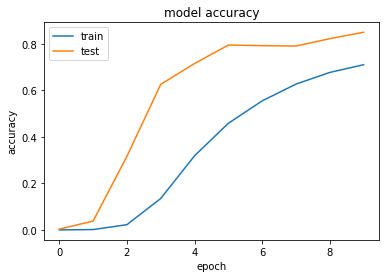

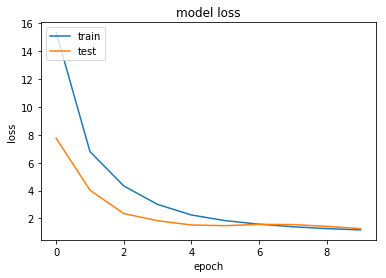

In [15]:
# plot
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_acc.png'.format(date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_loss.png'.format(date), bbox_inches='tight')
plt.show()

decode the output of the predictions into strings

In [33]:
def str_out(dataset = X_val):
    k_ctc_out = K.ctc_decode(sr_ctc.tm.predict(np.squeeze(dataset), 
                                                verbose = 1), 
                             np.array([28 for _ in dataset]))
    decoded_out = K.eval(k_ctc_out[0][0])
    str_decoded_out = []
    for i, _ in enumerate(decoded_out):     
        str_decoded_out.append("".join([index_map[c] for c in decoded_out[i] if not c == -1]))
        
    return str_decoded_out

In [22]:
y_pred_val = str_out()

6839/6839 [==============================] - 4s 606us/step


Turn the target array Y_val_all into strings with 'all_classes[Y_val_all[i]]'

In [44]:
print('PREDICTED: \t REAL:')
for i in range(10):
    print(y_pred_val[i], '\t\t',all_classes[Y_val_all[i]])

PREDICTED: 	 REAL:
three 		 three
cat 		 cat
marvin 		 marvin
up 		 up
riget 		 right
off 		 off
left 		 left
four 		 four
tree 		 tree
seven 		 seven


In [47]:
print(classification_report([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))

             precision    recall  f1-score   support

        yes       1.00      0.94      0.97       261
         no       0.96      0.82      0.88       270
         up       0.94      0.88      0.91       260
       down       0.98      0.81      0.89       264
       left       0.99      0.91      0.95       247
      right       0.98      0.88      0.93       256
         on       0.91      0.89      0.90       257
        off       0.96      0.28      0.43       256
       stop       0.99      0.89      0.94       246
         go       0.80      0.85      0.82       260
    silence       0.00      0.00      0.00        41
      house       1.00      0.95      0.97       173
       nine       0.98      0.87      0.92       230
       four       0.99      0.91      0.95       280
      happy       0.99      0.98      0.99       189
        wow       0.99      0.90      0.95       166
       five       0.97      0.82      0.89       242
       zero       1.00      0.93      0.96   

/home/chris/.conda/envs/deep/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


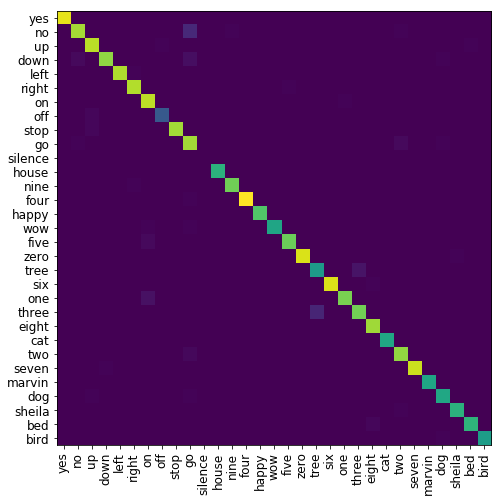

In [55]:
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))
plt.xticks(np.arange(0, len(all_classes)), all_classes, rotation = 'vertical', size = 12)
plt.yticks(np.arange(0, len(all_classes)), all_classes, size = 12)
plt.show()